# Se på antall sider 

In [1]:
from pathlib import Path

test_pages = list(
    Path("../data/transkribus_exports/test_data/2997983/Testsett_Samisk_OCR/").glob("*.jpg")
)
train_pages = list(Path("../data/transkribus_exports/train_data/train/").glob("**/*.jpg"))
side_30_pages = list(Path("../data/transkribus_exports/train_data/side_30/").glob("**/*.jpg"))
gt_pix_pages = list(Path("../data/transkribus_exports/train_data/GT_pix").glob("**/*.tif"))


print(f"""
Antall sider trening+validering     {len(train_pages)}
Antall sider test                   {len(test_pages)}
Antall sider side 30                {len(side_30_pages)}
Antall sider GT pix                 {len(gt_pix_pages)}
""")


Antall sider trening+validering     84
Antall sider test                   21
Antall sider side 30                2380
Antall sider GT pix                 82



# Se på antall dokumenter i data

In [2]:
import pandas as pd

train_df = pd.read_csv("../data/samisk_ocr_dataset/train/_metadata.csv")
manual_train_df = train_df[~train_df.page_30 & ~train_df.gt_pix]
page_30_df = train_df[train_df.page_30]
gt_pix_df = train_df[train_df.gt_pix]


val_df = pd.read_csv("../data/samisk_ocr_dataset/val/_metadata.csv")
test_df = pd.read_csv("../data/samisk_ocr_dataset/test/_metadata.csv")

In [3]:
print(
    f"""
Antall dokumenter 
Trening         {len(manual_train_df.urn.unique())}
Validering      {len(val_df.urn.unique())}
Test            {len(test_df.urn.unique())}
----
GT pix          {len(gt_pix_df.urn.unique())}
Side 30         {len(page_30_df.urn.unique())}
"""
)


Antall dokumenter 
Trening         12
Validering      15
Test            20
----
GT pix          82
Side 30         2310



## Språkvis

In [4]:
from ast import literal_eval
from collections import defaultdict


def print_language_overview(df: pd.DataFrame):
    lang_line_len = defaultdict(int)
    lang_page_len = defaultdict(int)
    lang_doc_len = defaultdict(int)
    total_pages = 0
    for langcodes, df_ in df.groupby("langcodes"):
        num_pages = 0
        for _, df__ in df_.groupby("urn"):
            num_pages += len(df__.page.unique())
        total_pages += num_pages

        langcodes = literal_eval(langcodes)
        if len(langcodes) > 1:
            for langcode in langcodes:
                lang_line_len[langcode] += len(df_) / 2
                lang_doc_len[langcode] += len(df_.urn.unique()) / 2
                lang_page_len[langcode] += num_pages / 2
        else:
            lang_line_len[langcodes[0]] += len(df_)
            lang_doc_len[langcodes[0]] += len(df_.urn.unique())
            lang_page_len[langcodes[0]] += num_pages

    for lang, num in lang_doc_len.items():
        print(f"Språk: {lang}")
        print(f"    Antall dokumenter:  {num} ({round(num/len(df.urn.unique())*100, 2)}%)")
        print(
            f"    Antall sider:       {lang_page_len[lang]} ({round(lang_page_len[lang]/total_pages*100, 2)}%)"
        )
        print(
            f"    Antall linjer:      {lang_line_len[lang]} ({round(lang_line_len[lang]/len(df)*100, 2)}%)"
        )
    print("\n")


print("Treningssett språkoversikt\n")
print_language_overview(manual_train_df)

print("Valideringssett språkoversikt\n")
print_language_overview(val_df)

print("Side 30 språkoversikt\n")
print_language_overview(page_30_df)

print("Testsett språkoversikt\n")
print_language_overview(test_df)

Treningssett språkoversikt

Språk: sma
    Antall dokumenter:  5 (41.67%)
    Antall sider:       9 (15.52%)
    Antall linjer:      208 (3.39%)
Språk: sme
    Antall dokumenter:  2.5 (20.83%)
    Antall sider:       37.0 (63.79%)
    Antall linjer:      5572.0 (90.73%)
Språk: smj
    Antall dokumenter:  2 (16.67%)
    Antall sider:       4 (6.9%)
    Antall linjer:      81 (1.32%)
Språk: smn
    Antall dokumenter:  2.5 (20.83%)
    Antall sider:       8.0 (13.79%)
    Antall linjer:      280.0 (4.56%)


Valideringssett språkoversikt

Språk: sma
    Antall dokumenter:  2 (13.33%)
    Antall sider:       2 (8.0%)
    Antall linjer:      53 (2.6%)
Språk: sme
    Antall dokumenter:  8 (53.33%)
    Antall sider:       18 (72.0%)
    Antall linjer:      1837 (90.27%)
Språk: smj
    Antall dokumenter:  2 (13.33%)
    Antall sider:       2 (8.0%)
    Antall linjer:      36 (1.77%)
Språk: smn
    Antall dokumenter:  3 (20.0%)
    Antall sider:       3 (12.0%)
    Antall linjer:      109 (5.36%

In [5]:
from collections import Counter

from nb_tokenizer import tokenize


def get_tokens(df: pd.DataFrame) -> Counter[str]:
    tokens = [t for text_line in df.text for t in tokenize(str(text_line))]
    return Counter(tokens)


train_tokens = get_tokens(manual_train_df)
s_30_tokens = get_tokens(page_30_df)
gt_pix_tokens = get_tokens(gt_pix_df)
val_tokens = get_tokens(val_df)

In [6]:
print(f"""Unike tokens:
    Train:      {'{:_}'.format(len(train_tokens))}
    Val:        {'{:_}'.format(len(val_tokens))}
    Side 30:    {'{:_}'.format(len(s_30_tokens))}
    GT pix:     {'{:_}'.format(len(gt_pix_tokens))}
""")

Unike tokens:
    Train:      9_998
    Val:        5_152
    Side 30:    110_936
    GT pix:     7_894



In [7]:
print(f"""Totalt antall tokens:
    Train:      {'{:_}'.format(sum(train_tokens.values()))}
    Side 30:    {'{:_}'.format(sum(s_30_tokens.values()))}
    Val:        {'{:_}'.format(sum(val_tokens.values()))}
    GT pix:     {'{:_}'.format(sum(gt_pix_tokens.values()))}

""")

Totalt antall tokens:
    Train:      31_926
    Side 30:    524_443
    Val:        11_891
    GT pix:     27_800




In [8]:
from typing import Any, Iterable


def percent_overlap(container1: Iterable[Any], container2: Iterable[Any]) -> float:
    intersection_len = len(set(container1).intersection(set(container2)))
    intersection_part = intersection_len / len(container1)
    return round(intersection_part * 100, 2)

In [9]:
print(f"""Tokenoverlapp
      
    Train og val:      
        {percent_overlap(val_tokens, train_tokens)}% av tokensa i val finnes i train
        {percent_overlap(train_tokens, val_tokens)}% av tokensa i train finnes i val

    Train og side 30:   
        {percent_overlap(train_tokens, s_30_tokens)}% av tokensa i train finnes i side 30
        {percent_overlap(s_30_tokens, train_tokens)}% av tokensa i side 30 finnes i train 
        
    Val og side 30:   
        {percent_overlap(val_tokens, s_30_tokens)}% av tokensa i val finnes i side 30
        {percent_overlap(s_30_tokens, val_tokens)}% av tokensa i side 30 finnes i val       
-----
    Train og GT pix:   
        {percent_overlap(train_tokens, gt_pix_tokens)}% av tokensa i train finnes i GT pix
        {percent_overlap(gt_pix_tokens, train_tokens)}% av tokensa i GT pix finnes i train 
        
    Val og GT pix:   
        {percent_overlap(val_tokens, gt_pix_tokens)}% av tokensa i val finnes i GT pix
        {percent_overlap(gt_pix_tokens, val_tokens)}% av tokensa i GT pix finnes i val       
      
""")

Tokenoverlapp
      
    Train og val:      
        25.82% av tokensa i val finnes i train
        13.3% av tokensa i train finnes i val

    Train og side 30:   
        48.58% av tokensa i train finnes i side 30
        4.38% av tokensa i side 30 finnes i train 
        
    Val og side 30:   
        57.53% av tokensa i val finnes i side 30
        2.67% av tokensa i side 30 finnes i val       
-----
    Train og GT pix:   
        4.83% av tokensa i train finnes i GT pix
        6.12% av tokensa i GT pix finnes i train 
        
    Val og GT pix:   
        4.91% av tokensa i val finnes i GT pix
        3.2% av tokensa i GT pix finnes i val       
      



## Forskjeller i tokens mellom settene

In [10]:
print(
    f"Antall tokens som bare fins i side 30:    {len(set(s_30_tokens) - (set(train_tokens).union(set(val_tokens).union(set(gt_pix_tokens)))))}"
)
print(
    f"Antall tokens som bare fins i GT pix:     {len(set(gt_pix_tokens) - set(s_30_tokens).union(set(train_tokens)).union(set(val_tokens)))}"
)
print(
    f"Antall tokens som bare fins i train:      {len(set(train_tokens) - set(s_30_tokens).union(set(val_tokens)).union(set(gt_pix_tokens)))}"
)
print(
    f"Antall tokens som bare fins i val:        {len(set(val_tokens) - set(s_30_tokens).union(set(train_tokens)).union(set(gt_pix_tokens)))}"
)

Antall tokens som bare fins i side 30:    102507
Antall tokens som bare fins i GT pix:     5490
Antall tokens som bare fins i train:      5027
Antall tokens som bare fins i val:        2094


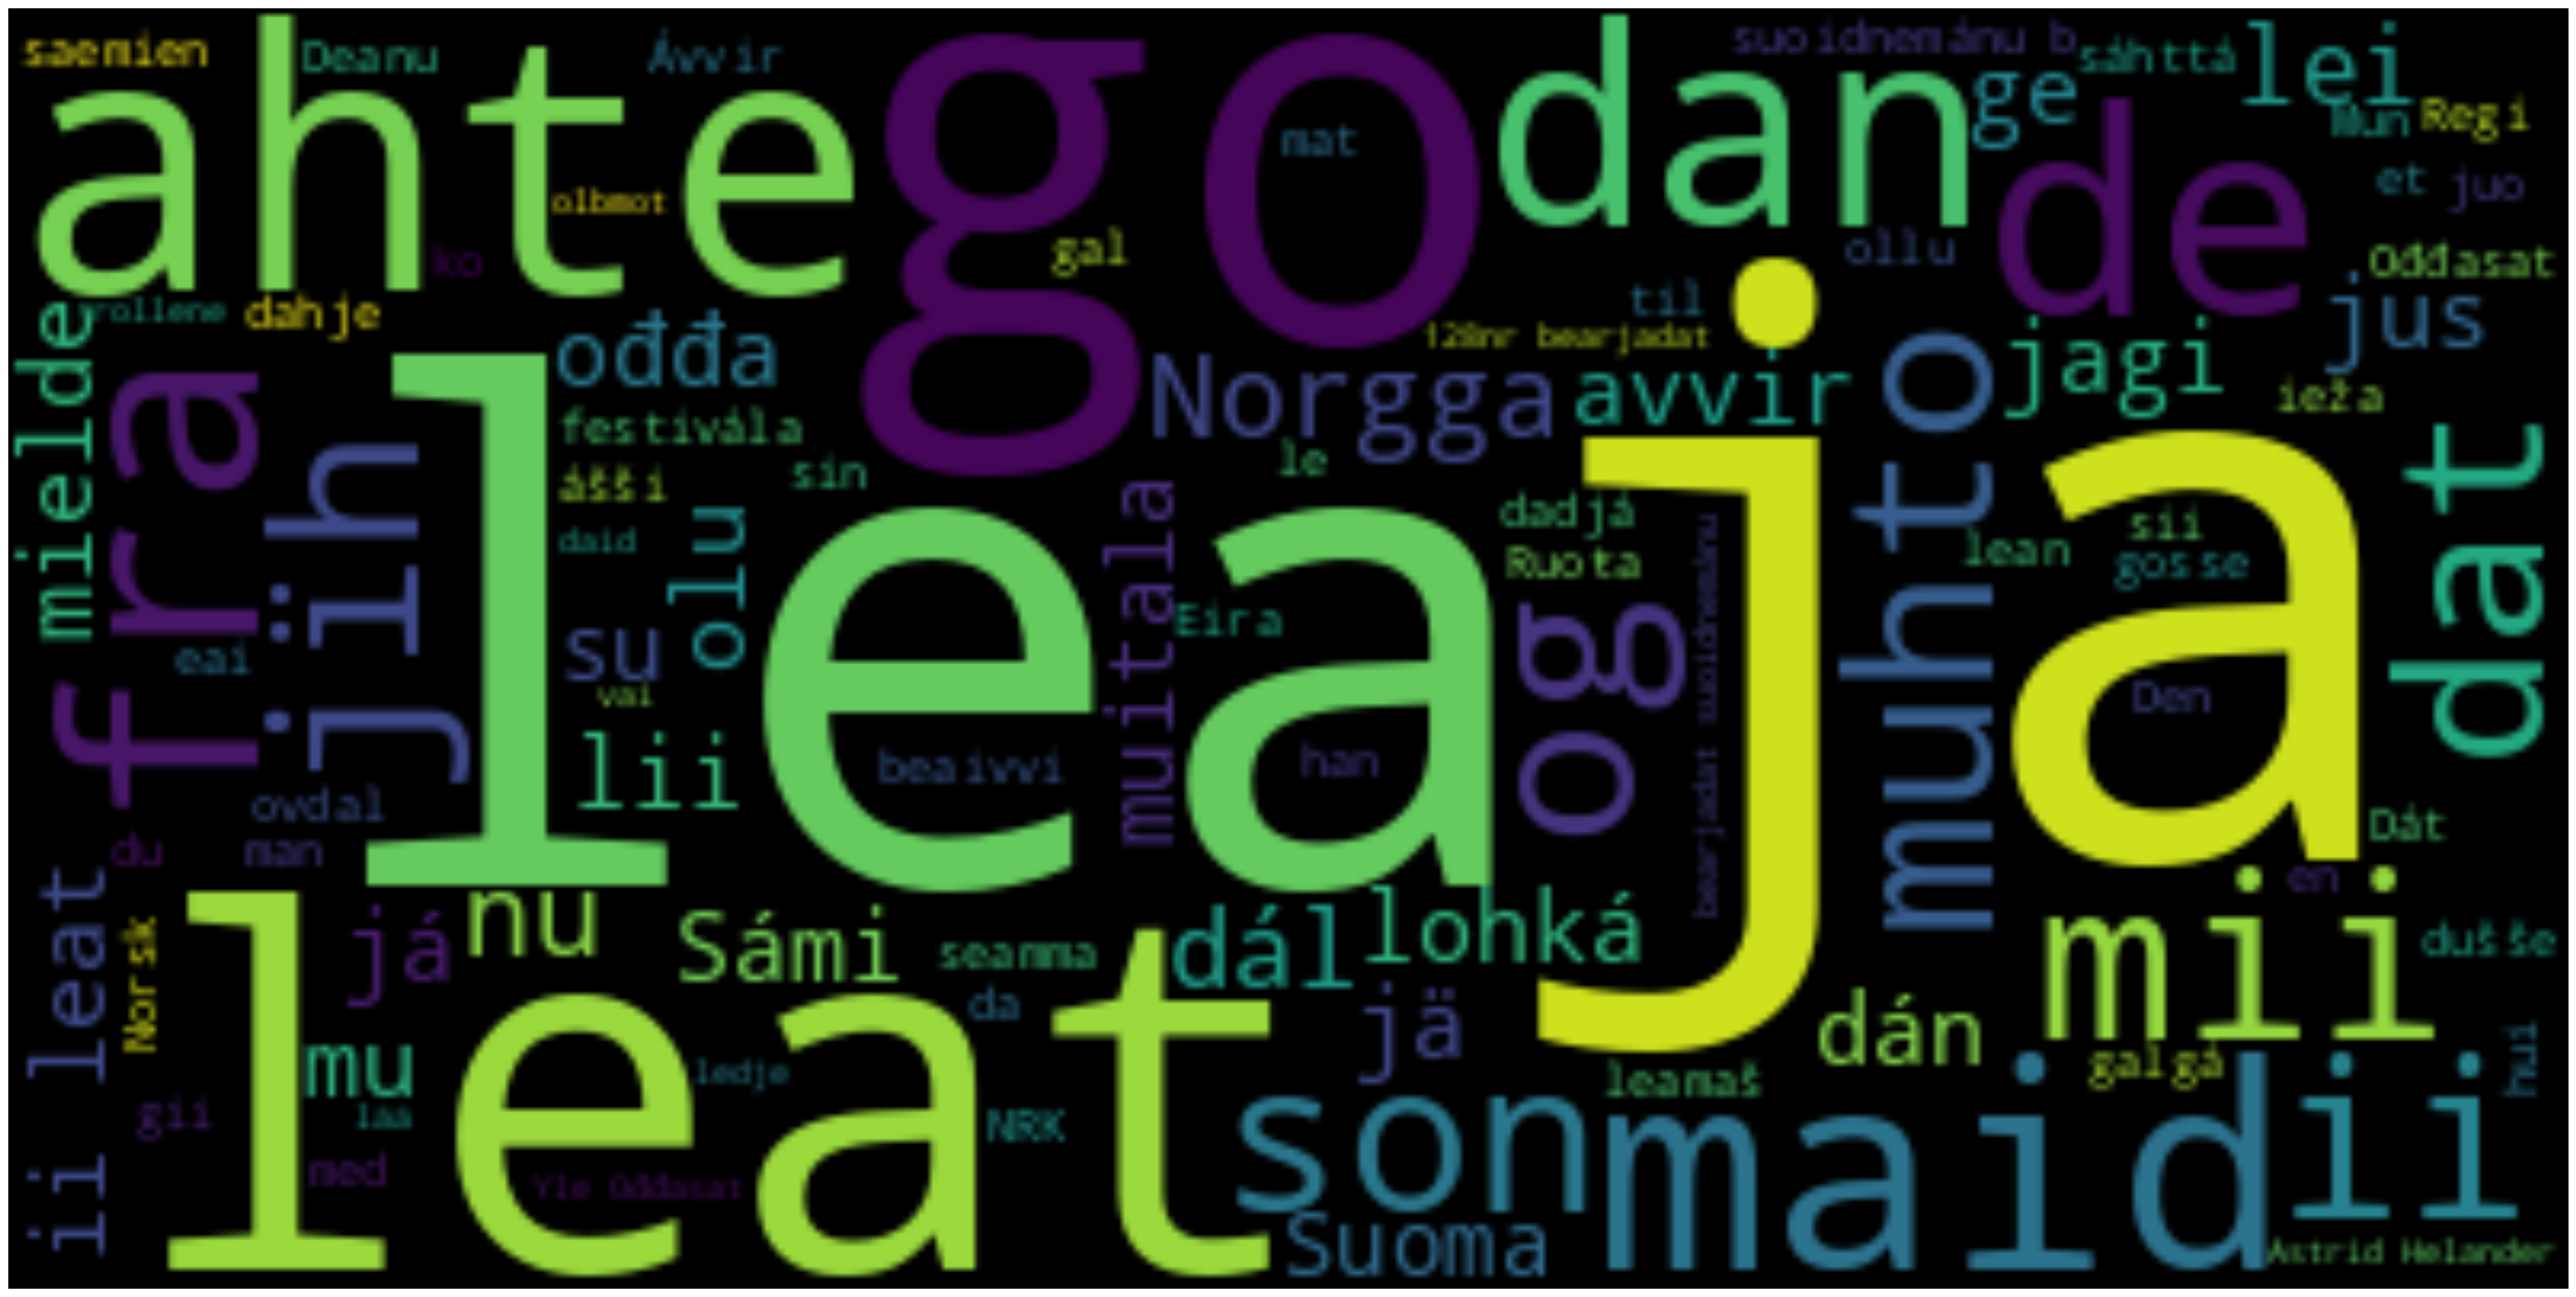

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from samisk_ocr.write_characters import get_text

train_text = get_text(manual_train_df)
train_cloud = WordCloud().generate(train_text)
plt.figure(figsize=(60, 20))
plt.imshow(train_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

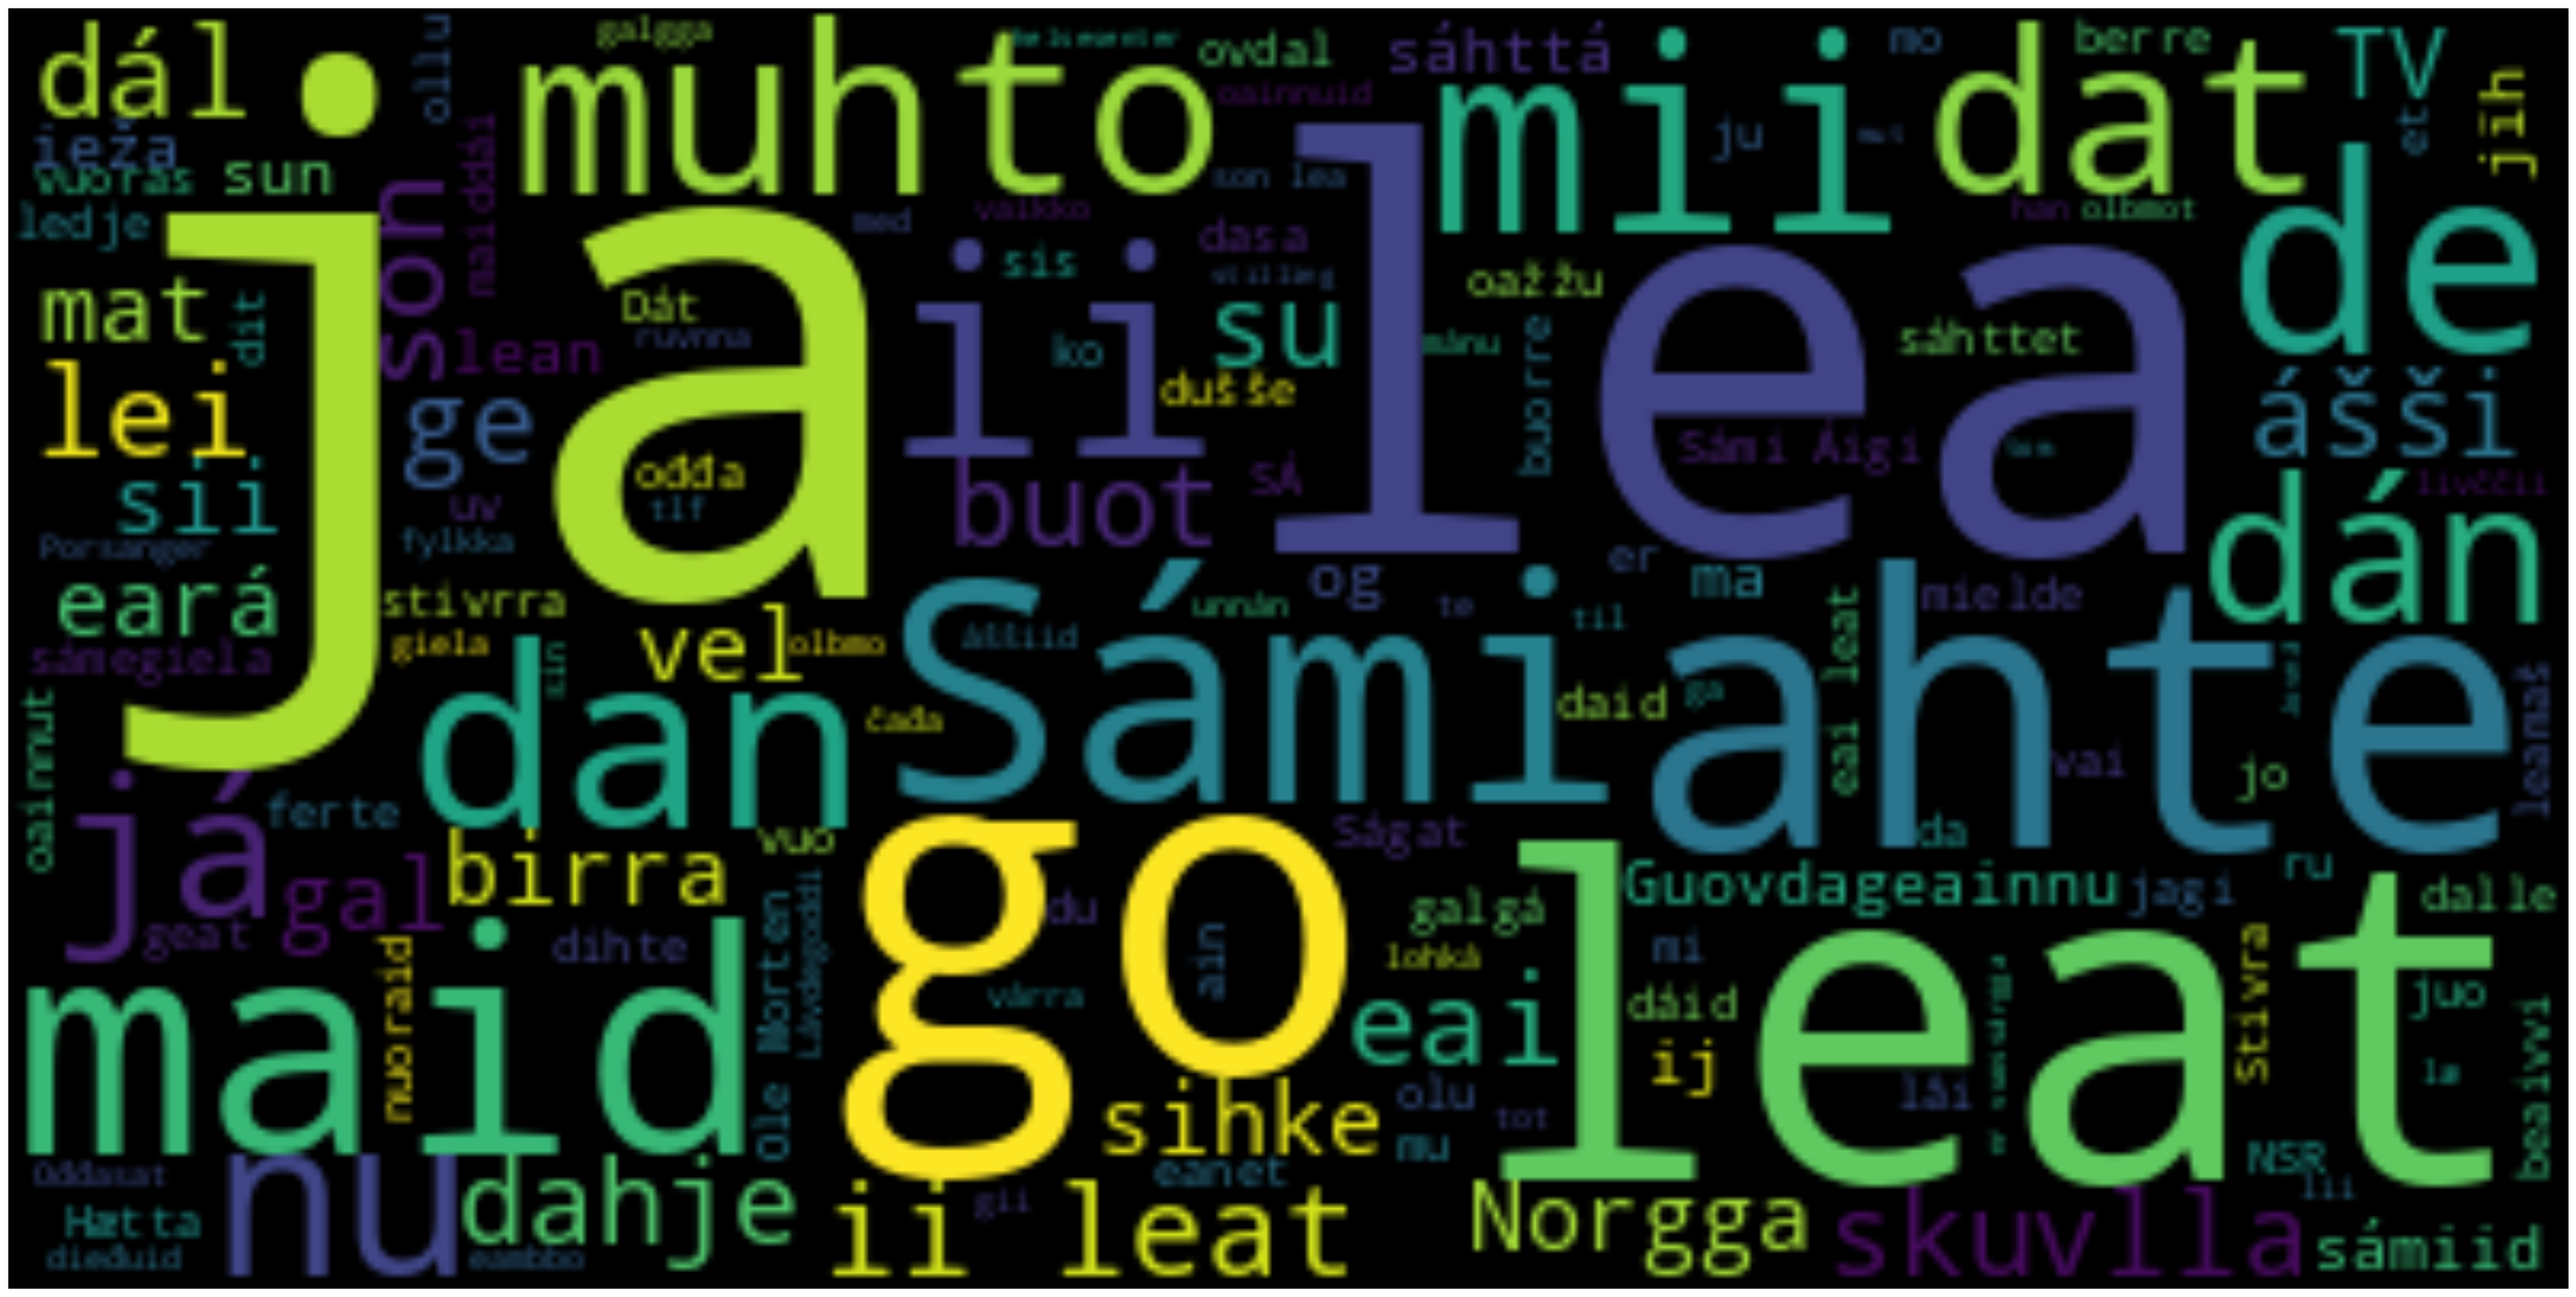

In [12]:
val_text = get_text(val_df)
val_cloud = WordCloud().generate(val_text)
plt.figure(figsize=(60, 20))
plt.imshow(val_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

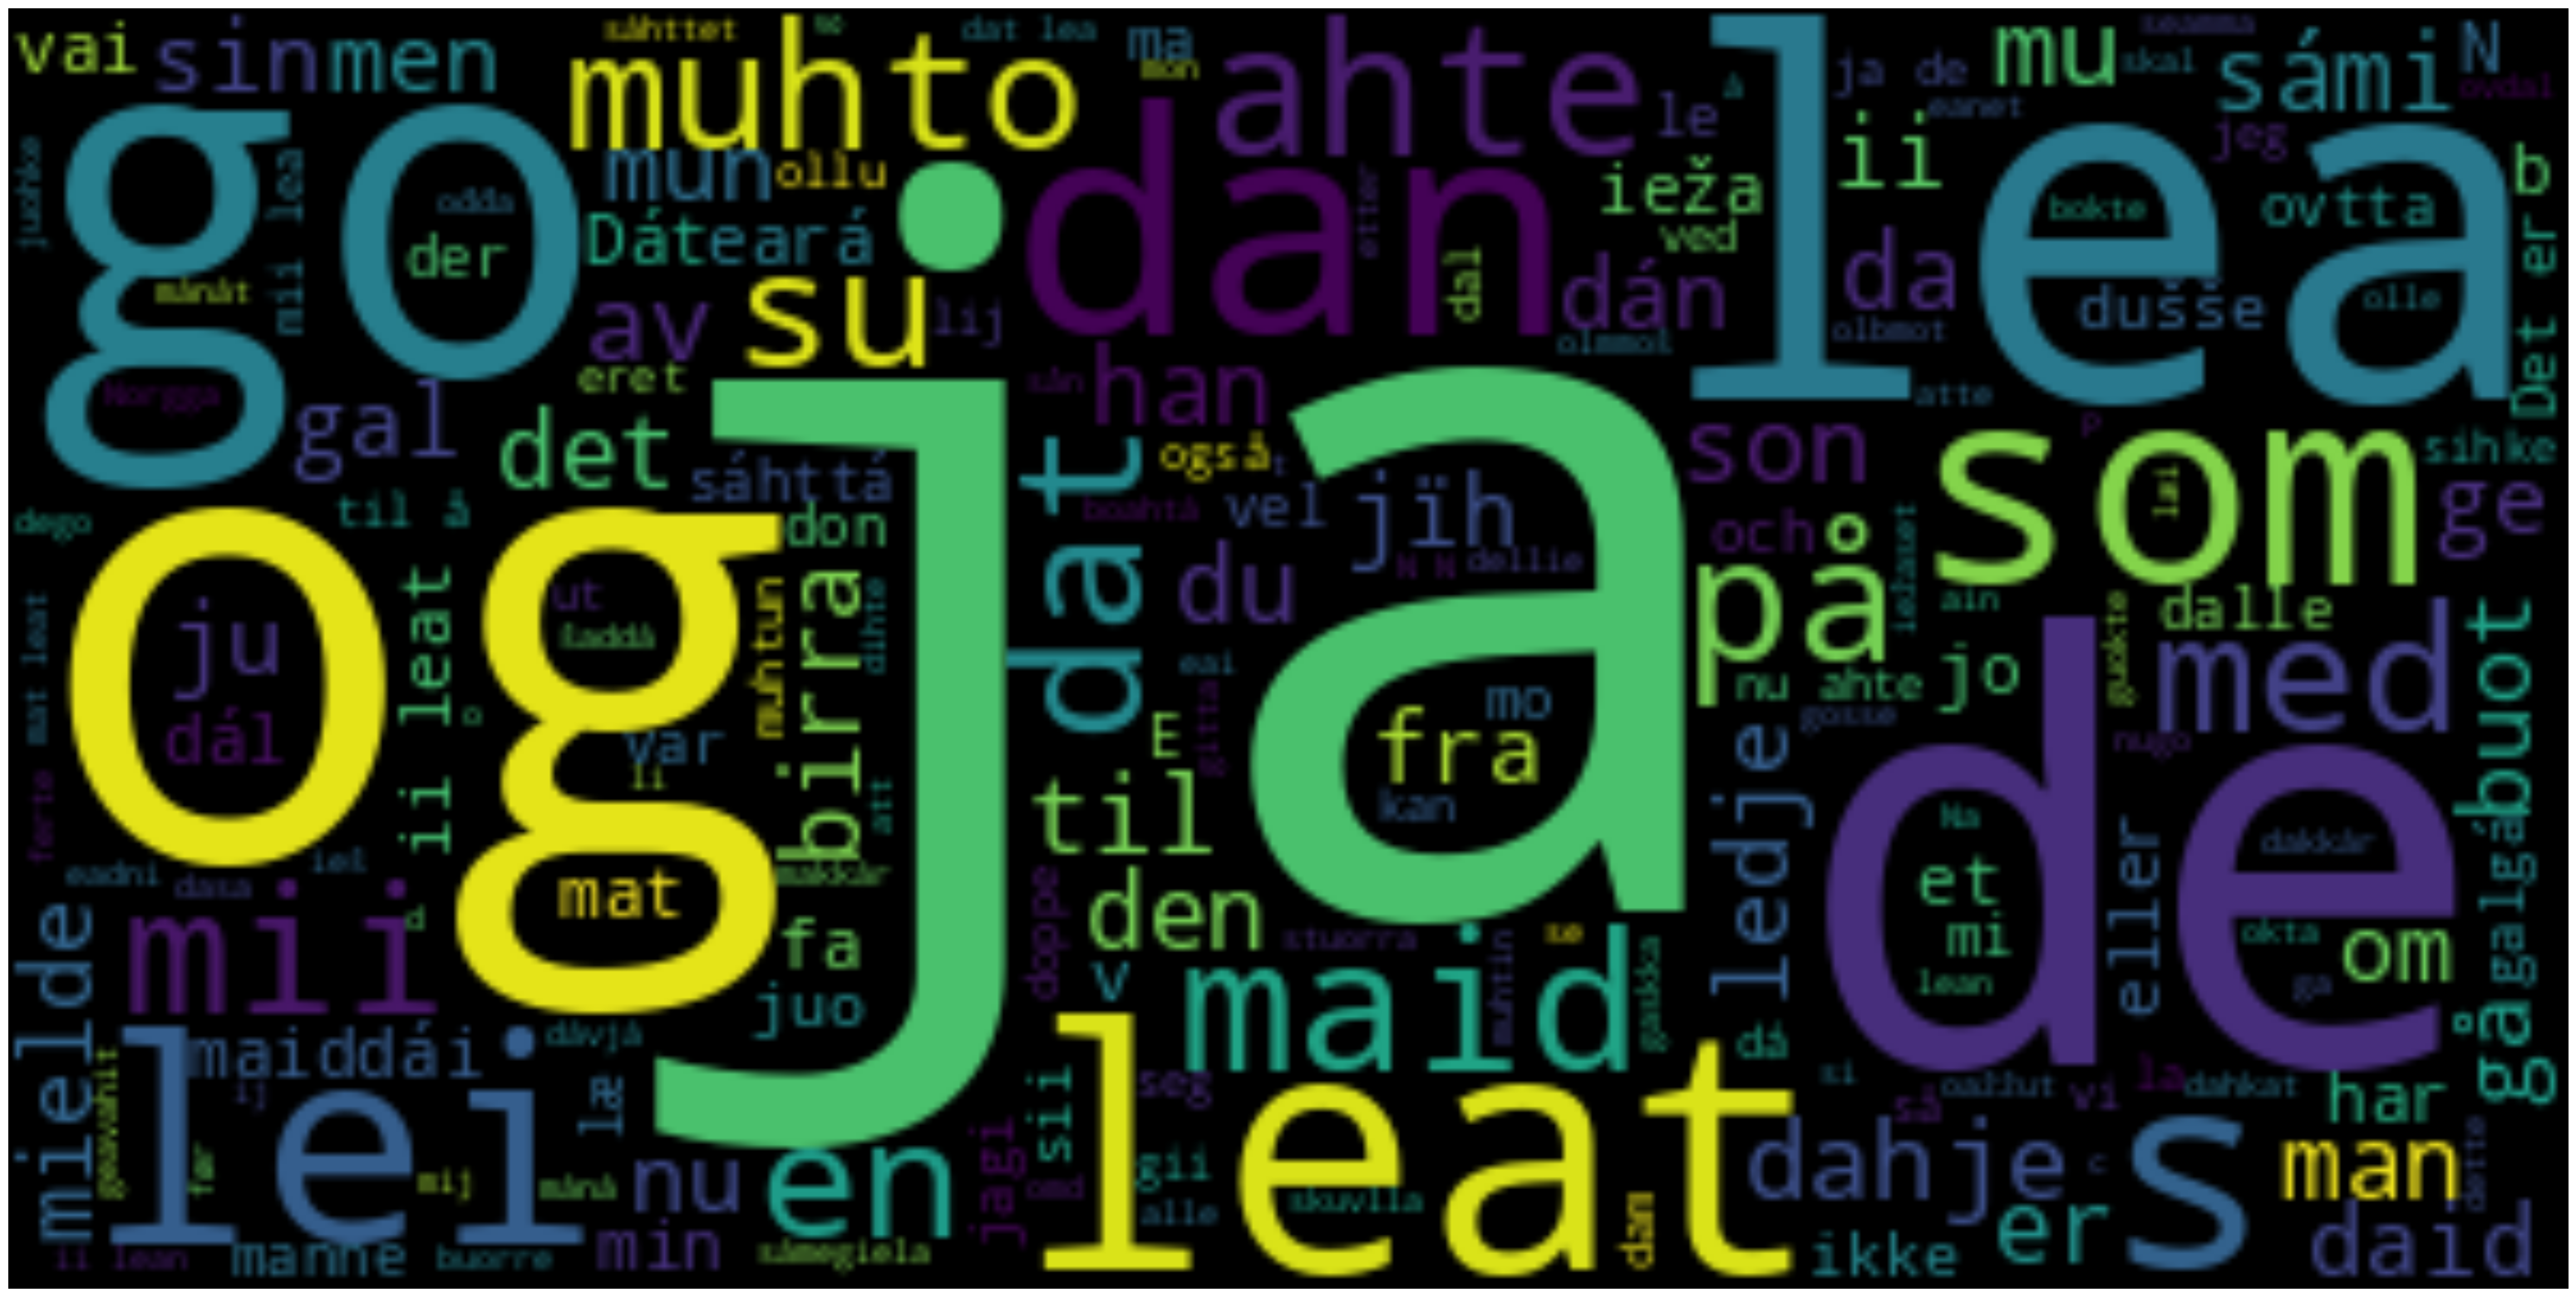

In [13]:
p_30_text = get_text(page_30_df)
p_30_cloud = WordCloud().generate(p_30_text)
plt.figure(figsize=(60, 20))
plt.imshow(p_30_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

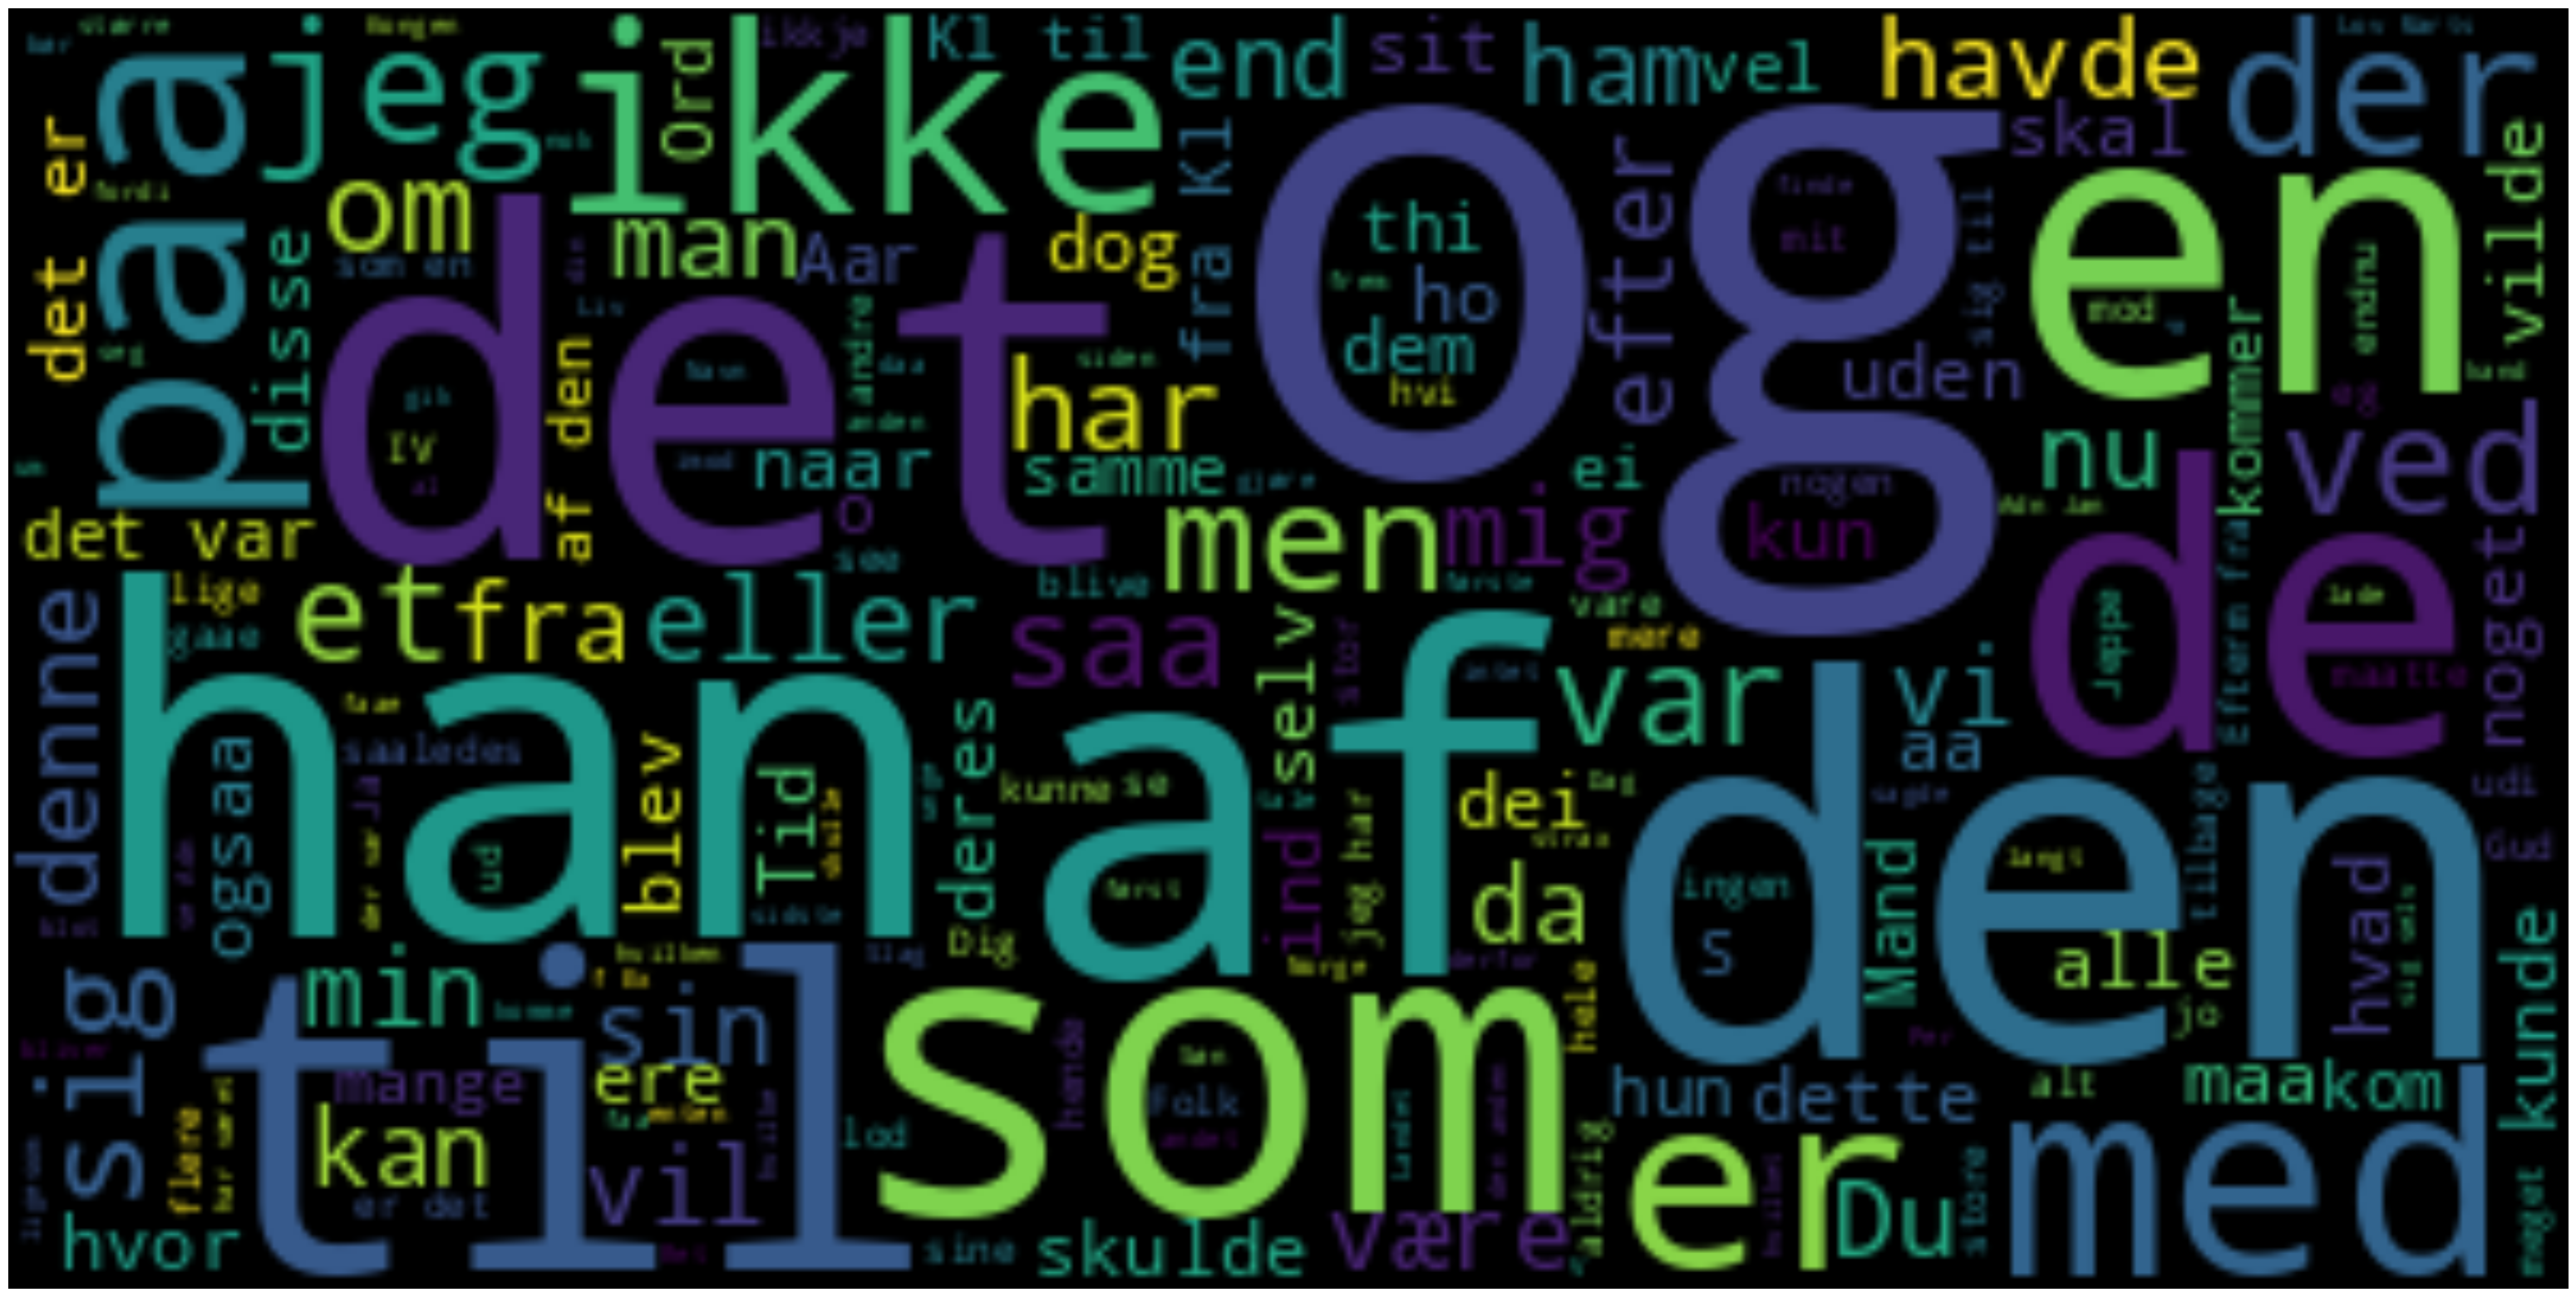

In [14]:
gt_pix_text = get_text(gt_pix_df)
gt_pix_cloud = WordCloud().generate(gt_pix_text)
plt.figure(figsize=(60, 20))
plt.imshow(gt_pix_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Se på bokstaver og tegn i data

In [15]:
train_chars = Counter(train_text)
s_30_chars = Counter(p_30_text)
val_chars = Counter(val_text)
gt_pix_chars = Counter(gt_pix_text)
test_chars = Counter(get_text(test_df))

print(f"""Unike tegn:
    Train:      {'{:_}'.format(len(train_chars))}
    Val:        {'{:_}'.format(len(val_chars))}
    Side 30:    {'{:_}'.format(len(s_30_chars))}
    GT pix:     {'{:_}'.format(len(gt_pix_chars))}

""")

print(f"""Totalt antall tegn:
    Train:      {'{:_}'.format(sum(train_chars.values()))}
    Side 30:    {'{:_}'.format(sum(s_30_chars.values()))}
    Val:        {'{:_}'.format(sum(val_chars.values()))}
    GT pix:     {'{:_}'.format(sum(gt_pix_chars.values()))}

""")

print(f"""Tegnoverlapp
      
    Train og val:      
        {percent_overlap(val_chars, train_chars)}% av tegna i val finnes i train
        {percent_overlap(train_chars, val_chars)}% av tegna i train finnes i val

    Train og side 30:   
        {percent_overlap(train_chars, s_30_chars)}% av tegna i train finnes i side 30
        {percent_overlap(s_30_chars, train_chars)}% av tegna i side 30 finnes i train 

    Val og side 30:   
        {percent_overlap(val_chars, s_30_chars)}% av tegna i val finnes i side 30
        {percent_overlap(s_30_chars, val_chars)}% av tegna i side 30 finnes i val   

----

    Train og GT pix:   
        {percent_overlap(train_chars, gt_pix_chars)}% av tegna i train finnes i GT pix
        {percent_overlap(gt_pix_chars, train_chars)}% av tegna i GT pix finnes i train       
      

    Val og GT pix:   
        {percent_overlap(val_chars, gt_pix_chars)}% av tegna i val finnes i GT pix
        {percent_overlap(gt_pix_chars, val_chars)}% av tegna i GT pix finnes i val       
      
""")

Unike tegn:
    Train:      121
    Val:        102
    Side 30:    133
    GT pix:     119


Totalt antall tegn:
    Train:      181_858
    Side 30:    2_984_651
    Val:        73_810
    GT pix:     136_031


Tegnoverlapp
      
    Train og val:      
        96.08% av tegna i val finnes i train
        80.99% av tegna i train finnes i val

    Train og side 30:   
        95.87% av tegna i train finnes i side 30
        87.22% av tegna i side 30 finnes i train 

    Val og side 30:   
        98.04% av tegna i val finnes i side 30
        75.19% av tegna i side 30 finnes i val   

----

    Train og GT pix:   
        76.86% av tegna i train finnes i GT pix
        78.15% av tegna i GT pix finnes i train       
      

    Val og GT pix:   
        81.37% av tegna i val finnes i GT pix
        69.75% av tegna i GT pix finnes i val       
      



## Forskjeller i tegn mellom settene

In [16]:
print(
    f"Bare i side 30: {list(set(s_30_chars) - (set(train_chars).union(set(val_chars)).union(set(gt_pix_chars))))}"
)

Bare i side 30: ['ǧ', 'ǩ']


In [17]:
print(
    f"Bare i train {list(set(train_chars) - set(s_30_chars).union(set(val_chars)).union(gt_pix_chars))}"
)

Bare i train ['û', '√', '€', 'Ž', '©']


In [18]:
print(
    f"Bare i val {list(set(val_chars) - set(s_30_chars).union(set(train_chars)).union(gt_pix_chars))}"
)

Bare i val ['ô', '_']


In [19]:
print(
    f"Bare i GT pix {list(set(gt_pix_chars) - set(s_30_chars).union(set(train_chars)).union(val_chars))}"
)

Bare i GT pix ['ç', '½', '⁷', 'í', 'ú', 'þ', '⁴', 'Þ', '□', '⅒', 'ɔ', '⁶']


In [20]:
print(f"Tegn i treningsdata som ikke er i valideringsdata: {set(train_chars) - set(val_chars)}")
print(f"Tegn i valideringsdata som ikke er i treningsdata: {set(val_chars) - set(train_chars)}")

Tegn i treningsdata som ikke er i valideringsdata: {'Ŋ', 'Æ', '·', '°', ']', 'ʒ', '*', 'Z', 'Ï', 'ǯ', 'Ž', 'û', '†', '§', '√', '€', 'õ', '©', '&', '+', 'ð', 'Ö', '['}
Tegn i valideringsdata som ikke er i treningsdata: {'ǥ', 'ô', '=', '_'}


# Hmmm hvorfor er D med strek bare i train OG bare i val?? 

In [21]:
elfdal_d = "Ð"
african_d = "Ɖ"
skolt_d = "Đ"

assert elfdal_d != african_d != skolt_d

print(val_chars[elfdal_d], train_chars[elfdal_d])
print(val_chars[african_d], train_chars[african_d])
print(val_chars[skolt_d], train_chars[skolt_d])

0 0
0 0
8 63


In [22]:
all_chars = sorted(list(set(train_chars).union(set(val_chars))))
unicode_code_points = [f"{ord(char):04X}" for char in all_chars]
links = [
    f"https://util.unicode.org/UnicodeJsps/character.jsp?a={code_point}"
    for code_point in unicode_code_points
]

val_counts = [val_chars[char] for char in all_chars]
train_counts = [train_chars[char] for char in all_chars]

df = pd.DataFrame(
    {
        "tegn": all_chars,
        "link": links,
        "antall_forekomster_train": train_counts,
        "antall_forekomster_val": val_counts,
    }
)
df.to_csv("tegn_og_bokstaver.tsv", sep="\t", index=False)
df

tegn                                               link  \
0         https://util.unicode.org/UnicodeJsps/character...   
1      !  https://util.unicode.org/UnicodeJsps/character...   
2      "  https://util.unicode.org/UnicodeJsps/character...   
3      %  https://util.unicode.org/UnicodeJsps/character...   
4      &  https://util.unicode.org/UnicodeJsps/character...   
..   ...                                                ...   
120    ʒ  https://util.unicode.org/UnicodeJsps/character...   
121    –  https://util.unicode.org/UnicodeJsps/character...   
122    †  https://util.unicode.org/UnicodeJsps/character...   
123    €  https://util.unicode.org/UnicodeJsps/character...   
124    √  https://util.unicode.org/UnicodeJsps/character...   

     antall_forekomster_train  antall_forekomster_val  
0                       25588                    9997  
1                          86                      26  
2                          78                     140  
3                           2                       5  
4                           3                       0  
..                        ...                     ...  
120                         1                       0  
121                       358                      53  
122                         3                       0  
123                         1                       0  
124                         4                       0  

[125 rows x 4 columns]

In [23]:
train_upper = Counter({char: count for char, count in train_chars.items() if char.isupper()})
train_lower = Counter({char: count for char, count in train_chars.items() if char.islower()})
val_upper = Counter({char: count for char, count in val_chars.items() if char.isupper()})
val_lower = Counter({char: count for char, count in val_chars.items() if char.islower()})
s30_upper = Counter({char: count for char, count in s_30_chars.items() if char.isupper()})
s30_lower = Counter({char: count for char, count in s_30_chars.items() if char.islower()})
gt_pix_upper = Counter({char: count for char, count in gt_pix_chars.items() if char.isupper()})
gt_pix_lower = Counter({char: count for char, count in gt_pix_chars.items() if char.islower()})